In [287]:
import shapely as sp
from shapely.geometry import Point, Polygon, LineString, MultiLineString, GeometryCollection
from shapely.ops import linemerge
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, SVG
%matplotlib notebook
from lxml import etree

In [177]:
def shapely_display_poly( poly, ax, fillkwargs={}, dotkwargs={} ):
    assert( type(poly) == Polygon )
    x, y = poly.exterior.xy
    ax.fill( x, y, **fillkwargs )
    ax.plot(x,y,".",**dotkwargs)

def shapely_display_line( line, ax, pltkwargs={} ):
    assert( type(line) == LineString )
    x, y = line.xy
    ax.plot(x,y,".-",**pltkwargs)

def shapely_display_multiline( mline, ax, pltkwargs={}):
    for line in mline:
        shapely_display_line( line, ax, pltkwargs )

In [178]:
p = Polygon([[0,0],[1,0],[1,1]])
p = LineString([[0,0],[1,0],[1,1]])


<IPython.core.display.Javascript object>


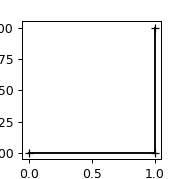

In [179]:
f = plt.figure(figsize=(2,2))
a = plt.gca()
shaply_display_line( p, a, dotkwargs={"c":"k","marker":"+"} )

In [231]:
def circle_segment( P, r, a1=0, a2=np.pi, d=10 ):
    """
    Cricle segment centerd on P, with r radius, start angle a1, end angle a2, made up of d segments
    """
    angles = np.linspace( a1, a2, d )
    x = np.sin( angles )*r + P.x
    y = np.cos( angles )*r + P.y
    return( zip( x, y ) )

def meander( l, r, n, d=10 ):
    """
    Very basic meander line, with l length straight lines, r radius bends, n straights total
    """
    lines = [ [[0,-i*2*r],[l,-i*2*r]][::-(1-i%2*2)] for i in range(n) ]
    circles = [ circle_segment( Point([l*(i%2),(-i*2-1)*r]), r, 0, -np.pi*(1-i%2*2), d=d) for i in range(n-1) ]
    meander = []
    for i in range(n-1):
        meander.extend( lines[i] )
        meander.extend( circles[i] )
    meander.extend( lines[n-1] )
    return( LineString(meander) )

<IPython.core.display.Javascript object>


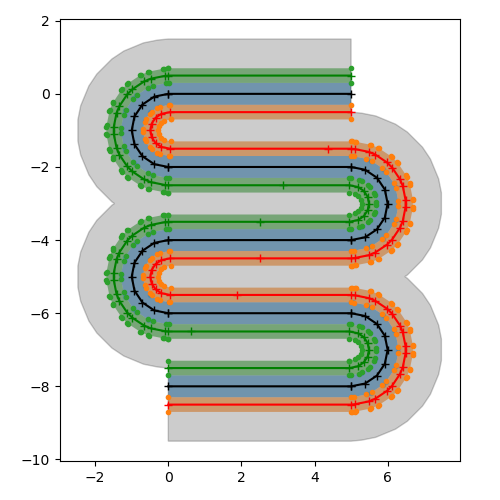

True
LineString


In [272]:
f = plt.figure(figsize=(5,5))
a = plt.gca()
a.set_aspect("equal")
c = circle_segment(Point([3,4]),2)
c = meander( 5, 1, 5, d=9 )
c2 = c.parallel_offset( .5, "left", resolution=1)
c3 = c.parallel_offset( .5, "right", resolution=1)
d = c.buffer(.3,cap_style=2, resolution=1)
douter = c.buffer(1.5,cap_style=2, resolution=1)
d2 = c2.buffer(.2,cap_style=2, resolution=1)
d3 = c3.buffer(.2,cap_style=2, resolution=1)
print(c.is_simple)
print(c.type)
shapely_display_line( c, a, pltkwargs={"c":"k","marker":"+"} )
shapely_display_line( c2, a, pltkwargs={"c":"r","marker":"+"} )
shapely_display_line( c3, a, pltkwargs={"c":"g","marker":"+"} )
shapely_display_poly( d, a, fillkwargs={"alpha":.5}, dotkwargs={"alpha":.3})
shapely_display_poly( d2, a, fillkwargs={"alpha":.5}, dotkwargs={"alpha":1})
shapely_display_poly( d3, a, fillkwargs={"alpha":.5}, dotkwargs={"alpha":1})
shapely_display_poly( douter, a, fillkwargs={"alpha":.2,"color":"k"}, dotkwargs={"alpha":0})
plt.tight_layout()

In [251]:
def generate_dots_sq( r, d, bounding_box ):
    x1,y1,x2,y2 = bounding_box
    nx = (x2-x1)/d
    ny = (y2-y1)/d
    dots = []
    for x in range( int(nx)+1 ):
        for y in range( int(ny)+1 ):
            dots.append( Polygon(circle_segment(Point(x*d+x1,y*d+y1),r,a1=0, a2=np.pi*2 ) ) )
    return( dots )

<IPython.core.display.Javascript object>


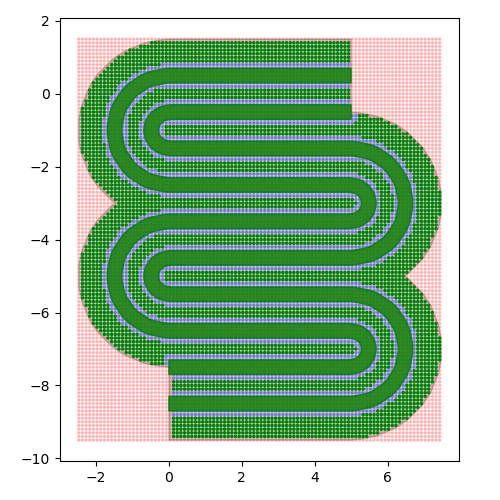

In [273]:
f = plt.figure(figsize=(5,5))
a = plt.gca()
a.set_aspect("equal")
shapely_display_poly( douter, a, fillkwargs={"alpha":.2,"color":"k"}, dotkwargs={"alpha":0})
dots = generate_dots_sq( .03, .1, douter.bounds )
for dot in dots:
    if douter.contains(dot) and not d2.contains(dot) and not d3.contains(dot):
        if d2.distance(dot) < .1 or d3.distance(dot) < .1:
            shapely_display_poly( dot, a, dotkwargs={"alpha":0}, fillkwargs={"color":"b","alpha":0.3} )
        else:
            shapely_display_poly( dot, a, dotkwargs={"alpha":0}, fillkwargs={"color":"g"} )
    else:
        shapely_display_poly( dot, a, dotkwargs={"alpha":0}, fillkwargs={"color":"r","alpha":0.2} )
shapely_display_poly( d2, a, fillkwargs={"alpha":.8,"color":"g"}, dotkwargs={"alpha":0})
shapely_display_poly( d3, a, fillkwargs={"alpha":.8,"color":"g"}, dotkwargs={"alpha":0})
plt.tight_layout()

In [286]:
display(SVG(f"<svg viewbox='-10 -10 20 20' ><g transform='scale(1)'>{d3.svg()}</g></svg>"))

In [327]:
d3s = etree.XML(d3.svg())
d2s = etree.XML(d2.svg())
dos = etree.XML(douter.svg())

In [328]:
d3s.attrib["stroke-width"] = ".0"
d2s.attrib["stroke-width"] = ".0"
dos.attrib["stroke-width"] = ".0"
dos.attrib["fill-opacity"] = ".4"

In [329]:
d3svg = etree.tostring(d3s)
d2svg = etree.tostring(d2s)
dosvg = etree.tostring(dos)

In [349]:
x1,y1,x2,y2 = douter.bounds
display(SVG(f"""
<svg viewbox='{x1} {y1} {x2-x1} {y2-y1}'  >
<g>
<defs>
    <pattern id="smallGrid" width=".5" height=".5" patternUnits="userSpaceOnUse">
      <path d="M .5 0 L 0 0 0 .5" fill="none" stroke="gray" stroke-width="0.05"/>
    </pattern>
    <pattern id="grid" width="2.5" height="2.5" patternUnits="userSpaceOnUse">
      <rect width="2.5" height="2.5" fill="url(#smallGrid)"/>
      <path d="M 2.5 0 L 0 0 0 2.5" fill="none" stroke="blue" stroke-width=".1"/>
    </pattern>
  </defs>

  
<rect x="{x1}" y="{y1}" width="{x2-x1}" height="{y2-y1}" fill="url(#grid)" fill-opacity=".5" />
</g>
<g transform='scale(1)'>
{d3svg}{d2svg}{dosvg}
</g>
</svg>"""))

In [ ]:
d2.b